In [1]:
import numpy as np

###Tensorflow keras neural network 

####MSE

In [2]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_pred - y_true) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    #print('MSE backward', self.y_pred.shape, self.y_true.shape, self.gradient.shape)
    return self.gradient

####Fit fuction

In [3]:
from typing import Callable

def fit(x: np.ndarray, y: np.ndarray, model: Callable, loss: Callable, lr: float, num_epochs: int):
  for epoch in range(num_epochs):
    y_pred = model(x)
    loss_value = loss(y_pred, y)
    if epoch % 20 == 0:
      print(f'Epoch {epoch}, loss {loss_value}')
    gradient_from_loss = loss.backward()
    model.backward(gradient_from_loss)
    model.update(lr)

####Linear model

In [4]:
class Linear:
  def __init__(self, input_dim: int, num_hidden: int = 1):
    self.weights = np.random.randn(input_dim, num_hidden) * np.sqrt(2. / input_dim)
    self.bias = np.zeros(num_hidden)
  
  def __call__(self, x):
    self.x = x
    output = x @ self.weights + self.bias
    return output

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum(axis=0)
    self.x_gradient = gradient @ self.weights.T
    return self.x_gradient

  def update(self, lr):
    self.weights = self.weights - lr * self.weights_gradient
    self.bias = self.bias - lr * self.bias_gradient

####Three dimention non-linear input generation

In [5]:
n = 200
d = 3
x = np.random.uniform(-1, 1, (n, d))

weights_true = np.array([[3, 1, -1],[2, 0, -2],]).T
bias_true = np.array([0.5, 0.1])

y_true = (x ** 2) @ weights_true + x @ weights_true + bias_true
print(f'x: {x.shape}, weights: {weights_true.shape}, bias: {bias_true.shape}, y: {y_true.shape}')

x: (200, 3), weights: (3, 2), bias: (2,), y: (200, 2)


#### Non-Linear Tensorflow/Keras model with 3 layers

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

inputs = keras.Input(shape=(3,))
l1 = layers.Dense(10, activation='relu', name='dense_1')(inputs)
l2 = layers.Dense(10, activation='relu', name='dense_2')(l1)
outputs = layers.Dense(2, name='regression')(l2)

model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())
model.compile(loss='mse', optimizer=optimizers.SGD(0.1))

model.fit(x, y_true, epochs=100)

y_pred = model(x)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
regression (Dense)           (None, 2)                 22        
Total params: 172
Trainable params: 172
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
7/7 [==============================] - 0s 2ms/step - loss: 4.6780
Epoch 2/100
7/7 [==============================] - 0s 2ms/step - loss: 3.7133
Epoch 3/100
7/7 [==============================] - 0s 2ms/step - loss: 2.1959
Epoch 4/100
7/7 [=====

####Plot the output and the real data using tsne

In [7]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def plot_comparison(y_true, y_pred):
  #tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, random_state=120)
  tsne = TSNE(n_components=2, random_state=0)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(yt_2d[:, 0], yt_2d[:, 1], c='b', label='y_true')
  plt.scatter(yp_2d[:, 1], yp_2d[:, 1], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Comparison')
  plt.xlabel('t_SNE1')
  plt.xlabel('t_SNE2')
  plt.show()

def plot_distribution(x, y_true, y_pred):
  tsne = TSNE(n_components=1, random_state=0)
  x_2d = tsne.fit_transform(x)
  yt_2d = tsne.fit_transform(y_true)
  yp_2d = tsne.fit_transform(y_pred)

  plt.figure(figsize=(6, 5))
  plt.scatter(x_2d[:, 0], yt_2d[:, 0], c='b', label='y_true')
  plt.scatter(x_2d[:, 0], yp_2d[:, 0], c='y', label='y_pred')
  plt.legend()
  plt.title('TSNE Y_True Y_Pred Distribution with X')
  plt.show()

def plot_3d(x, y, y_pred=None):
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  ax.scatter(x[:, 0], x[:, 1], y, label='y_true')
  if y_pred is not None:
    ax.scatter(x[:, 0], x[:, 1], y_pred, label='y_pred')
  plt.legend()

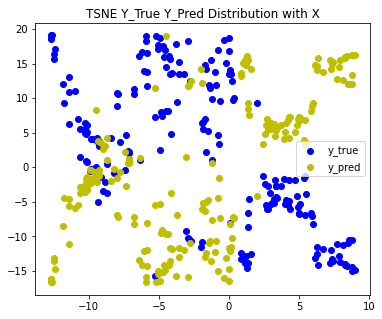

In [8]:
plot_distribution(x, y_true, y_pred)

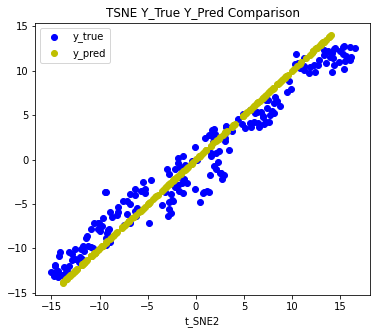

In [9]:
plot_comparison(y_true, y_pred)

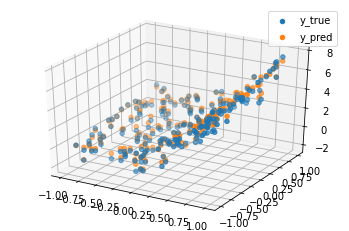

In [10]:
plot_3d(x, y_true[:, 0], y_pred=y_pred[:, 0])